In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
import scipy.integrate as integrate

import math
import pickle

import Lava as Lava

### <b> Comparison of upper surface cooling and crustal growth between Earth and Venus </b>

In [2]:
## read in data from Flynn and Mouginins-Mark 1992
data = pd.read_csv("FlynnMougnisMark_Puuoo.csv")

t_data = data.Seconds.to_numpy()
T_data = data.Tc.to_numpy()

In [3]:
Tlava = 1135 + 273
Ta_venus = 737 
Ta_earth = 30 + 273
Tsub_venus = Ta_venus
Tsub_earth = Ta_earth

## Thermal parameters
L = 3.2e5                 ## latent heat of fusion in J/kg; value from Wittmann et al.2017
k = 1
kappa = 5e-7

## Predefined set of lambdasfor solcing the transcendental Stefan problem
lambdas = np.arange(1.5, 0, -1e-5)

In [4]:
## Earth
Trange = np.arange(Tlava, Ta_earth, -5)

trange_earth = np.zeros_like(Trange, dtype = np.float32)
trange_venus_noconv = np.zeros((2, len(Trange)), dtype = np.float32)
trange_venus_snyder = np.zeros_like(Trange, dtype = np.float32)

upper_crust_earth = np.zeros_like(Trange, dtype = np.float32)
upper_crust_venus_noconv = np.zeros((2, len(Trange)), dtype = np.float32)
upper_crust_venus_snyder = np.zeros_like(Trange, dtype = np.float32)

In [5]:
l_final = 0
for i, T in enumerate(Trange):
    
    if Trange[i]==Tlava:
        trange_earth[i] = 0
        trange_venus_noconv[0,i] = 0
        trange_venus_noconv[1,i] = 0
        trange_venus_snyder[i] = 0
        
    else:
        ## Solving the Stefan problem to get lambda
        c = Lava.heat_capacity(T)
        rho = Lava.density(T)
        kappa = 1 / rho / c
        RHS = L * np.pi ** 0.5 / c / (Tlava - T)


        l = lambdas[np.argmin(np.abs(RHS - Lava.Stefan_lambda_upper_crust(lambdas)))]  


        ## Compute time at which surface temperature T is reached for Earth
        emis = 0.95
        Qrad = Lava.Radiation_flux(T, Ta_earth, emis)

        hconv = 50
        Qconv = Lava.Convection_flux(T, Ta_earth, hconv)

        t_sqroot = k * (Tlava - T) / erf(l) / (np.pi*kappa)**0.5 / (Qrad + Qconv)
        trange_earth[i] = t_sqroot**2
        upper_crust_earth[i] = Lava.crust_thickness(l, kappa, trange_earth[i])

        if T >= Ta_venus:
            ## Compute time at which surface temperature T is reached for Venus

            ## Mueller method
            emis = 0.95
            Qrad = Lava.Radiation_flux(T, Ta_venus, emis)
            Qconv1 = Lava.Convection_flux(T, Ta_venus, 1e-5)
            Qconv2 = Lava.Convection_flux(T, Ta_venus, 208)

            t_sqroot = k * (Tlava - T) / erf(l) / (np.pi*kappa)**0.5 / (Qrad + Qconv1)
            trange_venus_noconv[0,i] = t_sqroot**2
            upper_crust_venus_noconv[0, i] = Lava.crust_thickness(l, kappa, trange_venus_noconv[0,i] )
            t_sqroot = k * (Tlava - T) / erf(l) / (np.pi*kappa)**0.5 / (Qrad + Qconv2)
            trange_venus_noconv[1,i] = t_sqroot**2
            upper_crust_venus_noconv[1, i] = Lava.crust_thickness(l, kappa, trange_venus_noconv[1,i] )


            ## Flynn method
            Q_snyder = 1.07 * 1e-13 * T**4.85 * 1000                                                        ## heat flux in W/m2 using eq 8 of Flynn et al. 2023
            t_sqroot = k * (Tlava - T) / erf(l) / (np.pi*kappa)**0.5 / Q_snyder
            trange_venus_snyder[i] = t_sqroot**2
            upper_crust_venus_snyder[i] = Lava.crust_thickness(l, kappa, trange_venus_snyder[i] )
            
            l_final = l

            
        elif T < Ta_venus:
            trange_venus_noconv[0,i] = np.nan
            trange_venus_noconv[1,i] = np.nan
            trange_venus_snyder[i] = np.nan

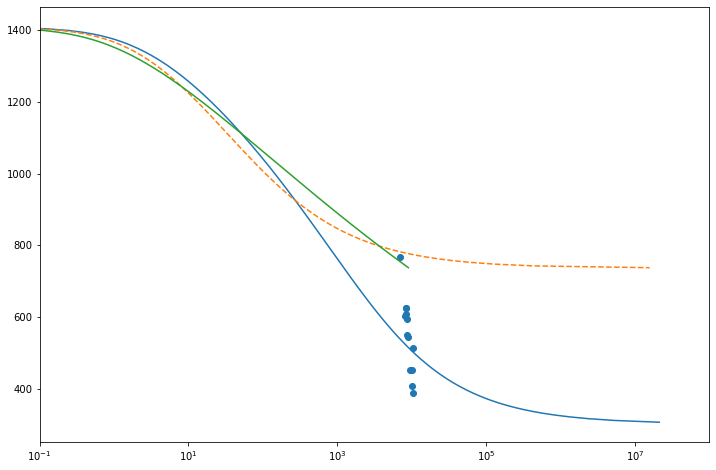

In [6]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(12, 8)

ax.plot(trange_earth, Trange)
# ax.plot(trange_venus_noconv[0], Trange, '--')
ax.plot(trange_venus_noconv[1], Trange, '--')
ax.plot(trange_venus_snyder, Trange)
ax.scatter(t_data, T_data)
ax.semilogx()
ax.set_xlim(1e-1, 1e8)
plt.show()

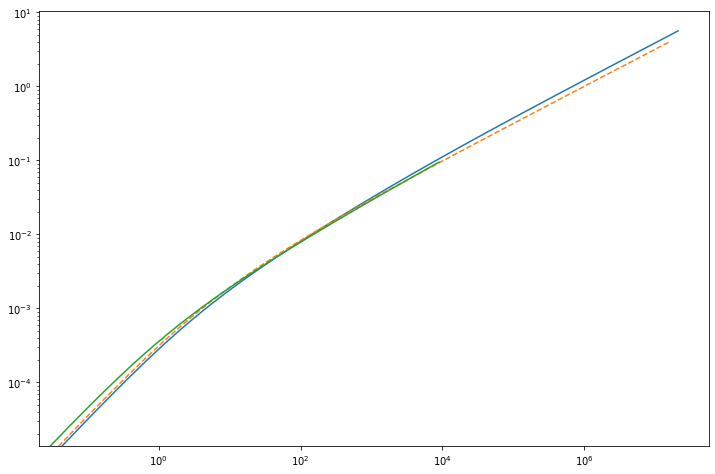

In [7]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(12, 8)

ax.plot(trange_earth, upper_crust_earth)
# ax.plot(trange_venus_noconv[0], upper_crust_venus_noconv[0], '--')
ax.plot(trange_venus_noconv[1], upper_crust_venus_noconv[1], '--')
ax.plot(trange_venus_snyder, upper_crust_venus_snyder)
# ax.scatter(t_data, T_data)
ax.semilogx()
ax.semilogy()
# ax.set_xlim(1e-1, 1e8)
plt.show()

### <b> Lava flow CAS model for a 10 m thick and 60m thick flow on Earth and Venus </b>

In [2]:
lava_thickness = [10, 60]

Tlava = 1135 + 273
Ta_venus = 737 
Ta_earth = 30 + 273
Tsub_venus = Ta_venus
Tsub_earth = Ta_earth

# ## Thermal parameters
# L = 3.2e5                 ## latent heat of fusion in J/kg; value from Wittmann et al.2017
# k = 1
# kappa = 5e-7

## Other variables
L = 100e3                    ## latent heat capacity in J/kg; value from Wittmann et al.2017
c =  1200                    ## specific heat capacity in J/kg/K; value from Wittman et al. 2017
k = 1                        ## thermal conductivity in W/m/K from Head and Wilson 1986, and Davies et al., 2005
rho = 2600                   ## Basalt density from Davies et al., 2006
kappa = k/rho/c              ## thermal diffusivity in m2/s;

## Predefined set of lambdasfor solcing the transcendental Stefan problem
lambdas = np.arange(1.5, 0, -1e-5)

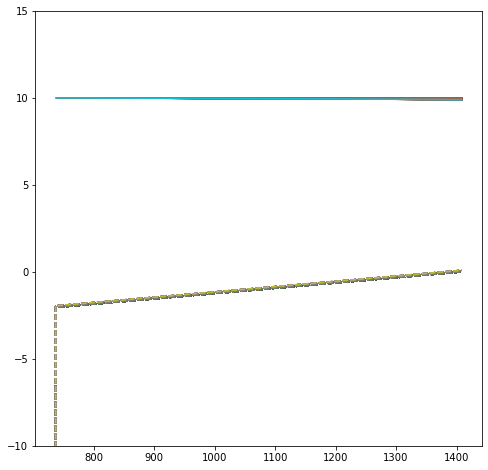

1.8012577666022944


In [3]:
## Case 1 - Venus 10 m
lt = lava_thickness[0]
zend = -100
dz = 1e-2
z = np.arange(zend, lt, dz)
dt = 10

Tsub = Tsub_venus
Ta = Ta_venus 

T_pre_eq = np.arange(Tlava-1, Tsub, -0.5)
t_pre_eq = np.zeros_like(T_pre_eq, dtype = np.float32)
t_eq = 0
Cup_pre_eq = np.zeros_like(T_pre_eq, dtype = np.float32)
Cbase_pre_eq = np.zeros_like(T_pre_eq, dtype = np.float32)

T_up = np.zeros((len(T_pre_eq), ), dtype=np.float32)

t_surface_eq = 0
l_lower = 0
l_upper = 0

fig, ax = plt.subplots(1,1)
fig.set_size_inches(8, 8)

for i, T in enumerate(T_pre_eq):
    c = Lava.heat_capacity(T)
    rho = Lava.density(T)
    kappa = Lava.diffusivity(1, rho, c)
    
    ################### Computation of lambda ###########################################
    # Upper crust
    RHS = L * np.pi ** 0.5 / c / (Tlava - T)
    l_up = lambdas[np.argmin(np.abs(RHS - Lava.Stefan_lambda_upper_crust(lambdas)))] 
    # Lower crust
    RHS_lower = L * np.pi ** 0.5 / c / (Tlava - Tsub)         
    l_base = lambdas[np.argmin(np.abs(RHS - Lava.Stefan_lambda_basal_crust(lambdas)))] 
    
    
    ################### Computation of fluxes and time ###################################
    Qsnyder = Lava.Snyder_flux(T)
    # Qrad = Lava.Radiation_flux(T, Ta)
    # Qconv = Lava.Convection_flux(T, Ta)
    Q = Qsnyder
    # Q = Qrad + Qconv
    t = Lava.getTime(T, Tlava, Q, l_up, k, kappa)
    t_pre_eq[i] = t
    t_eq = t
    
    ################### Computation of fluxes and time ###################################
    Cbase_pre_eq[i] = Lava.crust_thickness(l_base, kappa, t)
    Cup_pre_eq[i] = Lava.crust_thickness(l_up, kappa, t)
   
    ################### Check if the lava hassolidified ##################################
    if Cup_pre_eq[i] + Cbase_pre_eq[i] >= lt:
        print("lava solidification occured at or before ", t/3600, " hours")
        break
        

    ################### Computtemperature profile in the basal crust #######################
    y_base = np.linspace(zend, Cbase_pre_eq[i], 50)
    T_base = (((Tlava-Tsub) / (erf(l_base)+1)) * (1 + erf(y_base / 2/ (kappa*t)**0.5))) + Tsub
       
    ################### Computtemperature profile in the upper crust #######################
    y_up = np.linspace(0, Cup_pre_eq[i], 50)
    T_up = (((Tlava-T) / erf(l_up)) * erf((y_up) / 2/(kappa*t)**0.5)) + T

    

    ax.plot(T_base, y_base, "--")
    ax.plot(T_up, lt-y_up)
    
    
    

    
plt.ylim(-10, lt+5)
plt.show()
print(t_eq/3600)

In [3]:
### trying a differnet algorithm

## Case 1 - Venus 10 m
lt = lava_thickness[0]
zend = -100
dz = 1e-2
z = np.arange(zend, lt, dz)
dt = 10

Tsub = Tsub_venus
Ta = Ta_venus 

T_pre_eq = np.arange(Tlava-1, Tsub, -0.5)
t_pre_eq = np.zeros_like(T_pre_eq, dtype = np.float32)
l_up_pre_eq = np.zeros_like(T_pre_eq, dtype = np.float32)
l_base_pre_eq = np.zeros_like(T_pre_eq, dtype = np.float32)

t_eq = 0.0

t_solid_near = 0.0
t_solid = 0.0

C_up_pre_eq = np.zeros_like(T_pre_eq, dtype = np.float32)
C_base_pre_eq = np.zeros_like(T_pre_eq, dtype = np.float32)

T_up = np.zeros((len(T_pre_eq), ), dtype=np.float32)


for i, T in enumerate(T_pre_eq):
    # c = Lava.heat_capacity(T)
    # rho = Lava.density(T)
#     kappa = Lava.diffusivity(1, rho, c)
    
    ################### Computation of lambda ###########################################
    # Upper crust
    RHS = L * np.pi ** 0.5 / c / (Tlava - T)
    l_up_pre_eq[i] = lambdas[np.argmin(np.abs(RHS - Lava.Stefan_lambda_upper_crust(lambdas)))] 
    # Lower crust
    RHS_lower = L * np.pi ** 0.5 / c / (Tlava - Tsub)         
    l_base_pre_eq[i] = lambdas[np.argmin(np.abs(RHS - Lava.Stefan_lambda_basal_crust(lambdas)))] 
    
    
    ################### Computation of fluxes and time ###################################
    Qsnyder = Lava.Snyder_flux(T)
    # Qrad = Lava.Radiation_flux(T, Ta)
    # Qconv = Lava.Convection_flux(T, Ta)
    Q = Qsnyder
    # Q = Qrad + /Qconv
    t = Lava.getTime(T, Tlava, Q, l_up_pre_eq[i], k, kappa)
    t_pre_eq[i] = t
    t_eq = t
    
    ################### Computation of fluxes and time ###################################
    C_base_pre_eq[i] = Lava.crust_thickness(l_base_pre_eq[i], kappa, t)
    C_up_pre_eq[i] = Lava.crust_thickness(l_up_pre_eq[i], kappa, t)
    

   
    ################### Check if the lava has solidified ##################################
    if C_up_pre_eq[i] + C_base_pre_eq[i] >= lt:
        if t_solid_near == 0.0:
            t_solid_near = t
            T_solid_near = T
            print("upper_crust_thickness =", C_up_pre_eq[i])
            print("basal_crust_thickness =", C_base_pre_eq[i])
            print("lava solidification occured at or before ", t/3600, " hours")

In [4]:
## Find time of solidification if lava has already solidified
delt = 10

if t_solid_near != 0.0:
    print("Lava has alrteady solidified. Finding time of solidification....")
    idx = np.where(t_pre_eq == t_solid_near)[0][0]
    tstart = t_pre_eq[idx-1]
    tstop = t_pre_eq[idx]
    Tsurf_solid = T_pre_eq[idx]
    
    interval = np.arange(tstart, tstop+delt, delt) 
    
    l_up_start = l_up_pre_eq[idx-1]
    l_up_stop = l_up_pre_eq[idx]
    del_l_up = (l_up_start - l_up_stop) / len(interval)
    
    l_base_start = l_base_pre_eq[idx-1]
    l_base_stop = l_base_pre_eq[idx]
    del_l_base = (l_base_start - l_base_stop) / len(interval)
    
    for i in range(len(interval)):
        t = interval[i]
        l_up = l_up_start + i*del_l_up
        l_base = l_base_start + i*del_l_base
        
        C_base= Lava.crust_thickness(l_base, kappa, interval[i])
        C_up = Lava.crust_thickness(l_up, kappa, interval[i])       
        if C_up + C_base >= lt:
            print("upper_crust_thickness =", C_up)
            print("basal_crust_thickness =", C_base)
            print("Total crust thickness of ", C_up + C_base, " m was attained at time t = ", t_solid, " s")
            break  
            
        C_base_solid = C_base
        C_up_solid = C_up
        l_up_solid = l_up
        l_base_solid = l_base
        t_solid = interval[i]

elif t_solid_near == 0.0:
    print("Lava still not completely solid. Running forward in time to find point of solidification")
    l_up = l_up_pre_eq[-1]
    l_base = l_base_pre_eq[-1]
    l_up_solid = l_up
    l_base_solid = l_base
    Tsurf_solid = Ta
    
    
    t_post_eq = np.arange(t_eq+10, t_eq + 10*3.1536e7, 10)
    C_up_post_eq = np.zeros_like(t_post_eq, dtype = np.float32)
    C_base_post_eq = np.zeros_like(t_post_eq, dtype = np.float32)
    
    for i in range(len(t_post_eq)):
        C_base_post_eq[i] = Lava.crust_thickness(l_base, kappa, t_post_eq[i])
        C_up_post_eq[i] = Lava.crust_thickness(l_up, kappa, t_post_eq[i])
        
        if C_base_post_eq[i] + C_up_post_eq[i] >= lt:
            print("upper_crust_thickness =", C_up_post_eq[i])
            print("basal_crust_thickness =", C_base_post_eq[i])
            print("Total crust thickness of ", C_base_post_eq[i] + C_up_post_eq[i], " m was attained at time t = ", t_solid, " s")
            break   
            
        C_base_solid = C_base_post_eq[i]
        C_up_solid = C_up_post_eq[i]
        t_solid = t_post_eq[i]

Lava still not completely solid. Running forward in time to find point of solidification
upper_crust_thickness = 5.5223308
basal_crust_thickness = 4.47767
Total crust thickness of  10.000001  m was attained at time t =  16640816.084681328  s


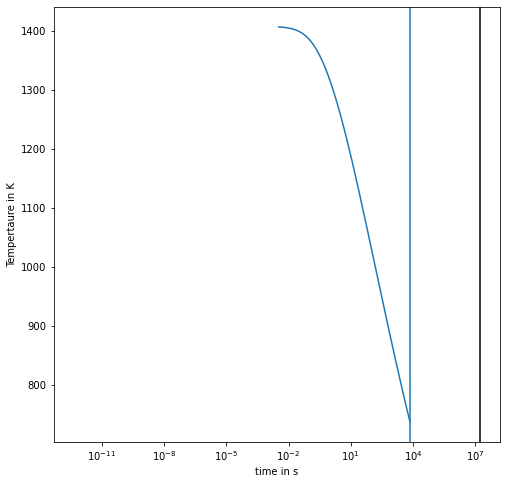

In [5]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(8, 8)

ax.plot(t_pre_eq, T_pre_eq)
ax.axvline(t_eq)
ax.axvline(t_solid_near, color = 'k', linestyle='--')
ax.axvline(t_solid, color = 'k')
ax.semilogx()

ax.set_xlabel("time in s")
ax.set_ylabel("Tempertaure in K")
plt.show()

In [6]:
print(t_solid / 3600)

4622.44891241148


In [7]:
# Temperature profiles of interest since eruption: 1 hour, 1 day, 1 week, 1 month, 1 year, 5 years, 10 years, and time of solidifcation
times = [24*3600, 7*24*3600, 30*24*3600, 90*24*3600, 365*24*3600, 2*365*24*3600, 5*365*24*3600, 10365*24*3600]
# times.sort()
times = np.array(times)
# times = np.array(times.sort())

In [8]:
try:
    t_lookup = np.concatenate((t_pre_eq, t_post_eq))
    C_base_lookup = np.concatenate((C_base_pre_eq, C_base_post_eq))
    C_up_lookup = np.concatenate((C_up_pre_eq, C_up_post_eq))
    l_up_lookup = np.concatenate((l_up_pre_eq, l_up_pre_eq[-1] * np.ones_like(t_post_eq)))
    l_base_lookup = np.concatenate((l_base_pre_eq, l_base_pre_eq[-1] * np.ones_like(t_post_eq)))
    Tsurf_lookup = np.concatenate((T_pre_eq, Ta * np.ones_like(t_post_eq)))
    print("solidification occured after surface equilibration")
except:
    t_lookup = t_pre_eq
    l_up_lookup = l_up_pre_eq
    l_base_lookup = l_base_pre_eq
    C_up_lookup = C_up_pre_eq
    C_base_lookup = C_base_pre_eq
    Tsurf_lookup = T_pre_eq
    print("solidification occured before surface equilibration")

presolid_idx = []
for i in range(len(times)):
    if times[i] <= t_solid:
        a = np.abs(times[i] - t_lookup).argmin()
        presolid_idx.append(a)

solidification occured after surface equilibration


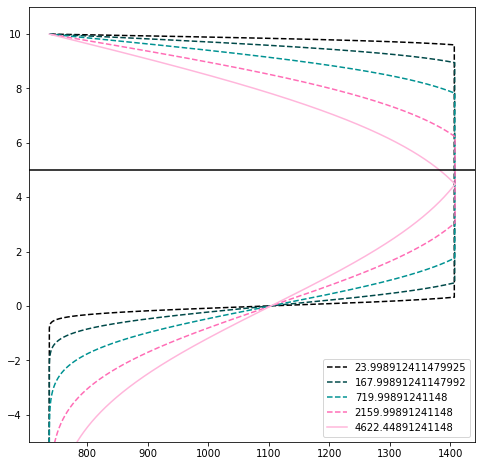

In [9]:
## Pre-solidification temperature calculation
fig, ax = plt.subplots(1,1)
fig.set_size_inches(8, 8)

colors = ["#000000","#004949","#009292","#ff6db6","#ffb6db",
 "#490092","#006ddb","#b66dff","#6db6ff","#b6dbff",
 "#920000","#924900","#db6d00","#24ff24","#ffff6d"]
color_idx = 0

zend = -100
dz = 1e-2
z = np.arange(zend, lt, dz)

        
T_preSC_up = []
T_preSC_base = []
        
z_preSC_up = []
z_preSC_base = []

T_preSC = []
z_preSC = []

for i in presolid_idx:
    t = t_lookup[i]
    C_up = C_up_lookup[i]
    C_base = C_base_lookup[i]
    l_up = l_up_lookup[i]
    l_base = l_base_lookup[i]
    Tsurf = Tsurf_lookup[i]
    
    ################### Compute temperature profile in the basal crust #######################
    y_base = np.arange(-100, C_base, dz)
    T_base = (((Tlava-Tsub) / (erf(l_base)+1)) * (1 + erf(y_base / 2/ (kappa*t)**0.5))) + Tsub
    T_preSC_base.append(T_base)
    z_preSC_base.append(y_base)
    
    ################### Compute temperature profile in the upper crust #######################
    y_up = np.arange(0, C_up, dz)
    T_up = (((Tlava-Tsurf) / erf(l_up)) * erf((y_up) / 2/(kappa*t)**0.5)) + Tsurf 
    T_preSC_up.append(T_up)
    z_preSC_up.append(lt-y_up)
    
    ################### Compute uniform temperature in the middle ############################
    y_mid = np.arange(y_base[-1]+dz, lt-y_up[-1], dz)
    T_mid = np.ones_like(y_mid) * T_base[-1]
    y_presolid = np.concatenate((y_base, y_mid, np.flip(lt-y_up)))
#     z_preSC = z_preSC - lt
    T_presolid = np.concatenate((T_base, T_mid, np.flip(T_up)))
    
    T_preSC.append(T_presolid)
    z_preSC.append(y_presolid)
    ax.plot(T_presolid, y_presolid , "--", color = colors[color_idx], label = t/3600)
    
    
#     ax.plot(T_base, y_base, "--", color = colors[color_idx], label = t/3600)
#     ax.plot(T_up, lt-y_up, color = colors[color_idx])
    color_idx += 1
    
    with open("preSolid10m.pkl", mode="wb") as f:
        pickle.dump([z_preSC, T_preSC], f)

    
################### Compute temperature profile at the time of solidification #######################
y_base_solid = np.arange(-100, C_base_solid, dz)
T_base_solid = (((Tlava-Tsub) / (erf(l_base_solid)+1)) * (1 + erf(y_base_solid / 2/ (kappa*t_solid)**0.5))) + Tsub

y_up_solid = np.arange(0, C_up_solid, dz)
T_up_solid = (((Tlava-Tsurf_solid) / erf(l_up_solid)) * erf((y_up_solid) / 2/(kappa*t_solid)**0.5)) + Tsurf_solid 

ax.plot(T_base_solid, y_base_solid, color = colors[color_idx], label = t_solid/3600)
ax.plot(T_up_solid, lt-y_up_solid, color = colors[color_idx])
 
# ax.axvline(Tlava, color='k')   
ax.axhline(lt/2, color='k')
ax.set_ylim(-5, lt+1)

plt.legend()
plt.show()

In [10]:
## Post-solidification temperature profile calculation

postsolid_times = times[times > t_solid].astype(float)
print(postsolid_times)


dt = 10                                                    ## delta_t in seconds
time_total = 5*365*24*3600
# t_range = np.arange(time_solid, time_total+dt, dt).astype(np.float32)

## Initial_condition
t = t_solid
z_SC = np.concatenate((y_base_solid, np.flip(lt-y_up_solid)), axis = 0)          ## join together lower crust z and upper crust z
T_SC = np.concatenate((T_base_solid, np.flip(T_up_solid)), axis = 0)          ## join together lower crust T and upper crust T

with open("Solid10m.pkl", mode="wb") as f:
    pickle.dump([z, T_SC], f)

## Note 1: Upper crust measuremnts are z downwards, so they need to be flipped 
## Note 2: The soldification point (z, T) are present in both the lower crust array and the upper crust array; removing the common (z, T) upper crust array.

m = 10
dprint = (time_total - t_solid) / m
printat = t_solid + dprint

T_postSC = np.zeros((m, len(z_SC)), dtype=np.float32)
# T_postSC = np.zeros((len(postsolid_times), len(z_range)), dtype=np.float32)

[3.15360e+07 6.30720e+07 1.57680e+08 8.95536e+08]


In [11]:
with open ("Solid10m.pkl", mode = "rb") as f:
    a = pickle.load(f)
with open ("preSolid10m.pkl", mode = "rb") as g:
    b = pickle.load(g)

0
1
2
3
4
5
6
7
8
9


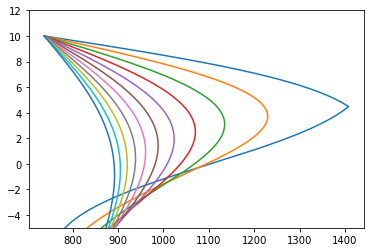

In [12]:
plt.figure()

T_n = T_SC
plt.plot(T_n, z_SC)

idx = 0
while t <= time_total:
    
    T_nplus = T_n + ( 
                    (kappa*dt/dz**2) * np.diff(T_n, n=2, prepend = T_n[0], append=T_n[-1]) 
                  )   
   
    t+=dt
    # # check whether to store output
    # if t in postsolid_times:
    #     print(idx, t)
    #     T_postSC[idx, :] = T_nplus
    #     idx += 1
    #     plt.plot(T_nplus, z_SC)
    #     if idx == len(postsolid_times):
    #         break
        
    # check whether to store output
    if t >= printat:
        print(idx)
        # print(t/3600/24)
        T_postSC[idx, :] = T_nplus
        printat += dprint
        idx += 1
        plt.plot(T_nplus, z_SC)
        
    # Update boundary_conditions

    T_nplus[-1] = Tsub    
    T_nplus[0] = Tsub
    
    
    # variables for next step
    T_n = T_nplus
    
    
plt.ylim(-5, lt + 2)
plt.show()   

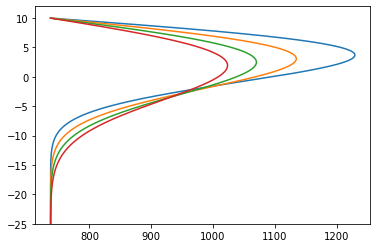

In [13]:
plt.figure()

for i in range(len(postsolid_times)):
    plt.plot(T_postSC[i], z_SC)
    
plt.ylim(-25, lt + 2)
plt.show()

In [14]:
## Effective temperature from integration of subsurface temperature

### EM properties
# thi_rad = np.deg2rad([45])
thi_rad = np.linspace(np.deg2rad(0), np.deg2rad(80), 20)
wv = 9.6e-2
eps1 = 5 + 0.01j
tand1 = eps1.imag / eps1.real
alpha = (2 * np.pi / wv) * np.sqrt(0.5*eps1.real * (np.sqrt(1 + tand1**2) - 1))
ka = 2 * alpha
beta = ka / np.cos(thi_rad)


num =  len(T_preSC) + len(postsolid_times) + 1

## before solidification
T_preSC_eff = []
for i in range(len(T_preSC_up)):
    z_base = z_preSC_base[i]
    z_up = z_preSC_up[i]
    T_base = T_preSC_base[i]
    T_up = T_preSC_up[i]
    z_mid = np.arange(z_base[-1]+dz, z_up[-1], dz)
    T_mid = np.ones_like(z_mid) * T_base[-1]
    z_preSC = np.concatenate((z_base, z_mid, np.flip(z_up)))
    z_preSC = z_preSC - lt
    T_preSC = np.concatenate((T_base, T_mid, np.flip(T_up)))
    
    T_preSC_eff_single = np.zeros(len(thi_rad), dtype = float)
    for j in range(len(thi_rad)):
        func = beta[j] * np.exp(beta[j] * z_preSC) * T_preSC
        T_preSC_eff_single[j] = integrate.simpson(func, z_preSC)
        T_preSC_eff.append(T_preSC_eff_single)
    
    ############ tried computing effective temperature from what is already stored earlier in T_preSC and z_preSC, but doesn't work; needs revisit ################
    # z_preSC_single = z_preSC[i] - lt
    # # need to figure oout how to integrate
    # T_preSC_eff_single = np.zeros(len(thi_rad), dtype = float)
    # for j in range(len(thi_rad)):
    #     func = beta[j] * np.exp(beta[j] * z_preSC_single) * T_preSC_single
    #     T_preSC_eff_single[j] = integrate.simpson(func, z_preSC_single)
    #     print(i,j, T_preSC_eff_single[j])
    # T_preSC_eff.append(T_preSC_eff_single)

    
## at the point of solidification
z_SC_downward = z_SC - lt               ### making top of lava surface as z = 0
T_SC_eff = np.zeros((len(thi_rad)), dtype=float)
for i in range(len(thi_rad)):
    func = beta[i] * np.exp(beta[i]* z_SC_downward) * T_SC 
    T_SC_eff[i] = integrate.simpson(func, z_SC_downward)

    
### after solidifcation
T_postSC_eff = np.zeros((len(thi_rad), len(postsolid_times)), dtype=float)

for i in range(len(thi_rad)):
    for j in range(len(postsolid_times)):
        # print(T_postSC[j])
        func = beta[i] * np.exp(beta[i] * z_SC_downward) * T_postSC[j]
        T_postSC_eff[i,j] = integrate.simpson(func, z_SC_downward)

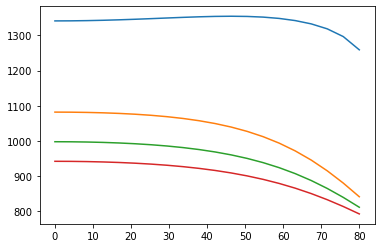

In [15]:
plt.figure()
plt.plot(np.rad2deg(thi_rad), T_preSC_eff[0])
plt.plot(np.rad2deg(thi_rad), T_SC_eff)
plt.plot(np.rad2deg(thi_rad), T_postSC_eff[:,0])
plt.plot(np.rad2deg(thi_rad), T_postSC_eff[:,1])
plt.show()

3600.0 3596.975 0.0008402506510416667
86400.0 86534.45 -0.03734809027777778
604800.0 603789.06 0.2808159722222222
2592000.0 2605228.8 -3.6746527777777778
31536000.0 29094360.0 678.2333333333333
157680000.0 147438510.0 2844.8577777777778
315360000.0 262163140.0 14776.906666666666
22678724.0 23561462.0 -245.205
